### Investigating the effect of behaviour complexity on manifold

In [1]:
'''
Dependencies
'''
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
from numpy import linalg as LA
from importlib import reload
from numpy import linalg as LA

import random
import re
from pyaldata import *
from rutils import *
from distance_methods import *
import distance_methods
from tqdm import tqdm as pbar
from scipy import stats
import statsmodels.api as sm

'''
Plotting aesthetics
'''
sns.set_style('white')
cs = ['#416ae6', '#F25346', '#31AD6F', '#7FB8DA', '#6A695B', '#2A3146']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=cs)
np.set_printoptions(suppress=True, precision=3)
sns.set_context('notebook', font_scale = 1.2, rc = {'lines.linewidth':2, })

'''
Magic commands
'''
%config InlineBackend.figure_format = 'retina'

/Users/Daphne/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
'''
Note: VR sessions have typically more neurons than CF sessions
'''

sessions = [
    'Chewie_CO_VR_2016-09-09.mat', # File Matt used to generate initial figures
    'Chewie_CO_VR_2016-09-12.mat',
    'Chewie_CO_VR_2016-09-14.mat',
    'Chewie_CO_VR_2016-10-06.mat',
    'Mihili_CO_VR_2014-03-03.mat',
    'Mihili_CO_VR_2014-03-04.mat',
    'Mihili_CO_VR_2014-03-06.mat',
    'Chewie_CO_FF_2016-09-15.mat',
    'Chewie_CO_FF_2016-09-21.mat',
    'Chewie_CO_FF_2016-10-05.mat',
    'Chewie_CO_FF_2016-10-07.mat',
    'Mihili_CO_FF_2014-02-03.mat',
    'Mihili_CO_FF_2014-02-17.mat',
    'Mihili_CO_FF_2014-02-18.mat',
    'Mihili_CO_FF_2014-03-07.mat'
]

session = sessions[1]
print('------------------------------')
print(f'Selected session: {session}')
print('------------------------------')

# Data path
df = mat2dataframe('/Users/Daphne/Data/' + session, shift_idx_fields=True)

# Get the date of the session and monkey name for plotting later
date = '-'.join(re.findall('[0-9]+', session))
monkey = session[:1]

# Read in cmp file and get electrode map
m1_emap  = localize_elecs(read_cmp(file_path='/Users/Daphne/Data/Chewie Left M1 SN 6250-001474.cmp'), elecs=range(1,97))
pmd_emap = localize_elecs(read_cmp(file_path='/Users/Daphne/Data/Chewie Left PMd SN 6251-001469.cmp'), elecs=range(1,97))

------------------------------
Selected session: Chewie_CO_VR_2016-09-12.mat
------------------------------


In [3]:
warnings.filterwarnings('ignore')

# Combine bins 
td = combine_time_bins(df, n_bins=3)

# Remove low firing neurons
td = remove_low_firing_neurons(td, signal='M1_spikes',  threshold=0)
td = remove_low_firing_neurons(td, signal='PMd_spikes', threshold=0)

# Sqrt transform neurons
td = transform_signal(td, signals='M1_spikes',  transformations='sqrt')
td = transform_signal(td, signals='PMd_spikes', transformations='sqrt')

# Merge signals
td = merge_signals(td, ['M1_spikes', 'PMd_spikes'], 'both_spikes')

# Calculate firing rates from spikes, works on '_spikes' fields and automatically divides by bin_size
td = add_firing_rates(td, 'smooth', std=0.05)

# Select only baseline (BL) trials
td = td.loc[td['epoch'] == 'BL']

N_m1 = td.M1_spikes[0].shape[1]
N_pmd = td.PMd_spikes[0].shape[1]
num_neurons = td.both_rates[1].shape[1]

print(f'Number of neurons before processing: {df.M1_spikes[0].shape[1]+ df.PMd_spikes[0].shape[1]} \
        => After processing: {td.M1_spikes[0].shape[1]+ td.PMd_spikes[0].shape[1]} (M1: {td.M1_spikes[0].shape[1]}, PMd: {td.PMd_spikes[0].shape[1]})')

Number of neurons before processing: 239         => After processing: 239 (M1: 77, PMd: 162)


In [4]:
td.target_direction.unique()[:2]


array([ 0.   , -1.571])

In [5]:
'''CHOOSE TARGET'''

target_angle = td.target_direction.unique()
#td_target_angle = td.loc[td['target_direction'] == target_angle]
td_target_angle = td[td['target_direction'].isin(target_angle)]

print(f'Selecting all rows with target angle: {target_angle}')

Selecting all rows with target angle: [ 0.    -1.571  3.142  2.356 -0.785  0.785 -2.356  1.571]


In [6]:
len(td_target_angle.target_direction)

237

In [7]:
# This is the trial-concatenated data on which we will perform dimensionality reduction
X_concat = np.concatenate(td['both_rates'].values, axis=0).T

X_concat.shape # (neurons x timepoints)

(239, 32374)

### Perform PCA on M1 and PMd recordings separately

Perform PCA on M1 and PMd recordings separately

In [8]:
td, model_m1 = tools.dim_reduce(td_target_angle, PCA(n_components=N_m1), 'M1_rates', 'M1_pca', return_model=True)
m1_pcs = model_m1.components_.T

In [9]:
td, model_pmd = tools.dim_reduce(td_target_angle, PCA(n_components=N_pmd), 'PMd_rates', 'PMd_pca', return_model=True)
pmd_pcs = model_pmd.components_.T

Perform PCA on all recordings together

In [10]:
# Perform PCA on the trial concatenated trialdata
td, model_m1pmd = tools.dim_reduce(td_target_angle, PCA(n_components=num_neurons), 'both_rates', 'both_pca', return_model=True)
m1pmd_pcs = model_m1pmd.components_.T

## Computing $\rho_{ij}$ and $d_{ij}$

In [11]:
def corrs_and_distances_within(L, unit_guide, emap, metric='corr'):
    ''' Compute pairwise correlations and corresponding physical distances within an MAE.
    '''
    N = L.shape[0] # Number of neurons
    C = []
    D = []
    
    for i in range(N):
        for j in range(i+1, N): # No repetition
            
            if metric == 'euclid':
                # Compute euclidean distance between PCs
                ed_ij = LA.norm(L[i, :] - L[j, :])
                C.append(ed_ij)

            else:
                # Compute correlation between PCs 
                rho_ij, _ = stats.pearsonr(L[i, :], L[j, :])
                C.append(rho_ij)
                
            # Compute spatial distance within MAE between neuron pair
            elec_i = unit_guide[i, 0]
            elec_j = unit_guide[j, 0]
            loc_i = np.array(np.where(m1_emap == elec_i))
            loc_j = np.array(np.where(m1_emap == elec_j))
            
            D.append(LA.norm(loc_i - loc_j))
            
    return np.array(C), np.array(D)

In [12]:
def corrs_and_distances(L, m1_unit_guide, pmd_unit_guide, m1_emap, pmd_emap, metric='corr', OTHER_ARRAY_D=50):
    ''' Compute pairwise correlations and corresponding physical distance. 
    
    Parameters
    ----------
    L: np array
        Latent variables (manifold) of dimension N x K, where K is the dimensionality of the manifold
    
    [name]_unit_guide: np array
        maps neurons to electrodes 
    
    [name]_emap: np array
        maps electrode number to location on array
        
    OTHER_ARRAY_D: int
        distance placeholder for when neurons are each on different arrays 
    
    Returns
    -------
    C: np array
        correlations between each unique neuron pair
    D: np array
        respective spatial distances between each neuron pair
    A: np array of str
        indicates to which array neuron pair belongs: 'M1', 'PMd' or '0A' if between comparison
    '''
    
    N = L.shape[0] 
    C = [] # Correlations
    D = [] # Spatial distances
    A = [] # On which array is the neuron pair

    for i in range(N):
        for j in range(i+1, N): # NO repetition
            
            if metric == 'euclid':
                # Compute euclidean distance between PCs
                ed_ij = LA.norm(L[i, :] - L[j, :])
                C.append(ed_ij)

            else:
                # Compute correlation between PCs 
                rho_ij, _ = stats.pearsonr(L[i, :], L[j, :])
                C.append(rho_ij)

            # Compute spatial distance between neurons
            if i < m1_unit_guide.shape[0] and j < m1_unit_guide.shape[0]: # If both neurons are located on M1 array (within)

                elec_i, elec_j = m1_unit_guide[i, 0], m1_unit_guide[j, 0] # Locate neuron on electrode
                loc_i, loc_j = np.array(np.where(m1_emap == elec_i)), np.array(np.where(m1_emap == elec_j)) 
                D.append(LA.norm(loc_i - loc_j))
                A.append('M1')

            elif i >= m1_unit_guide.shape[0] and j >= m1_unit_guide.shape[0]: # If both neurons are on the PMD arr (within)

                k = i - m1_unit_guide.shape[0]
                p = j - m1_unit_guide.shape[0]
                
                elec_i, elec_j = pmd_unit_guide[k, 0], pmd_unit_guide[p, 0] 
                loc_i, loc_j = np.array(np.where(pmd_emap == elec_i)), np.array(np.where(pmd_emap == elec_j)) 
                D.append(LA.norm(loc_i - loc_j))
                A.append('PMd')

            else: # If neuron i and j are located on different arrays
                D.append(OTHER_ARRAY_D)
                A.append('OA')

    return np.array(C), np.array(D), np.array(A)

## Track evolution of stats over # of PCs

In [13]:
''' Parameters '''
pc_range_all = range(1, num_neurons)
pc_range_m1 = range(1, N_m1)
pc_range_pmd = range(1, N_pmd)
OTHER_ARRAY_D = 50

### 1. All recordings & control

In [14]:
def track_evo_pcs(td, pcs, m1_emap, pmd_emap):
    ''' Compute statistics for a range of PCs '''
    
    td.reset_index(inplace=True)
    
    K = td.both_rates[1].shape[1] # Total number of neurons/PCs
    means = np.zeros((3, K-1)) # 3 (same elec: 0, same arr: 1, other arr: 2) x number of PCs
    medians = np.zeros((3, K-1))
    stds = np.zeros((3, K-1))
    
    for i, k in pbar(enumerate(range(1, K))):
        
        # Take first k PCs 
        L = pcs[:, :k]
        
        # Compute spatial and euclidean distances between PC weights 
        E, D, A = corrs_and_distances(L, td['M1_unit_guide'][0], td['PMd_unit_guide'][0], 
                                      m1_emap, pmd_emap, metric='euclid')
        
        # Convert to dataframe and categorize based on spatial distances 
        df = pd.DataFrame(data = {'euclidean distance': E, 'distance': D, 'on array': A})
        df['category'] = df['distance'].apply(lambda d: 'same electrode' if d == 0 else \
                                              ('same array' if d < OTHER_ARRAY_D else ('other array')))
        
        # Compute all means
        means[0, i] = df.loc[np.where((df['category'] == 'same electrode')), 'euclidean distance'].mean()
        means[1, i] = df.loc[np.where((df['category'] == 'same array')), 'euclidean distance'].mean()
        means[2, i] = df.loc[np.where((df['category'] == 'other array')), 'euclidean distance'].mean()
        
        medians[0, i] = df.loc[np.where((df['category'] == 'same electrode')), 'euclidean distance'].median()
        medians[1, i] = df.loc[np.where((df['category'] == 'same array')), 'euclidean distance'].median()
        medians[2, i] = df.loc[np.where((df['category'] == 'other array')), 'euclidean distance'].median()
        
        stds[0, i] = df.loc[np.where((df['category'] == 'same electrode')), 'euclidean distance'].std()
        stds[1, i] = df.loc[np.where((df['category'] == 'same array')), 'euclidean distance'].std()
        stds[2, i] = df.loc[np.where((df['category'] == 'other array')), 'euclidean distance'].std()
        
    return np.array(means), np.array(medians), np.array(stds)

Run for empirical data

In [15]:
means_emp, medians_emp, stds_emp = track_evo_pcs(td, m1pmd_pcs, m1_emap, pmd_emap)

238it [04:31,  1.14s/it]


### 2. Within M1 and PMd separately

In [16]:
# WITHIN
m1_within_mean = np.zeros((4, td.M1_rates[1].shape[1]-1)) 
m1_within_median = np.zeros((4, td.M1_rates[1].shape[1]-1))
m1_within_std = np.zeros((4, td.M1_rates[1].shape[1]-1))

pmd_within_mean = np.zeros((4, td.PMd_rates[1].shape[1]-1))
pmd_within_median = np.zeros((4, td.PMd_rates[1].shape[1]-1))
pmd_within_std = np.zeros((4, td.PMd_rates[1].shape[1]-1))

In [17]:
i = 0

for K in pbar(pc_range_m1):

    # === WITHIN M1 ===
    L_m1 = m1_pcs[:, :K]
    E_m1_within, D_m1_within = corrs_and_distances_within(L=L_m1, unit_guide=td['M1_unit_guide'][1], emap=m1_emap, metric='euclid')

    # Convert to dataframe and make intervals
    df_m1 = pd.DataFrame(data = {'within E-distance': E_m1_within, 'within S-distance': D_m1_within})
    df_m1['interval'] = pd.cut(df_m1['within S-distance'], bins=[-0.1, 0.001, 2.01, 4.01, OTHER_ARRAY_D], labels=['0', '(0, 2]','(2, 4]', '(4, inf)'])

    m1_within_mean[0, i] = df_m1.loc[df_m1['interval'] == '0']['within E-distance'].mean()
    m1_within_mean[1, i] = df_m1.loc[df_m1['interval'] == '(0, 2]']['within E-distance'].mean()
    m1_within_mean[2, i] = df_m1.loc[df_m1['interval'] == '(2, 4]']['within E-distance'].mean()
    m1_within_mean[3, i] = df_m1.loc[df_m1['interval'] == '(4, inf)']['within E-distance'].mean()

    m1_within_median[0, i] = df_m1.loc[df_m1['interval'] == '0']['within E-distance'].median()
    m1_within_median[1, i] = df_m1.loc[df_m1['interval'] == '(0, 2]']['within E-distance'].median()
    m1_within_median[2, i] = df_m1.loc[df_m1['interval'] == '(2, 4]']['within E-distance'].median()
    m1_within_median[3, i] = df_m1.loc[df_m1['interval'] == '(4, inf)']['within E-distance'].median()

    m1_within_std[0, i] = df_m1.loc[df_m1['interval'] == '0']['within E-distance'].std()
    m1_within_std[1, i] = df_m1.loc[df_m1['interval'] == '(0, 2]']['within E-distance'].std()
    m1_within_std[2, i] = df_m1.loc[df_m1['interval'] == '(2, 4]']['within E-distance'].std()
    m1_within_std[3, i] = df_m1.loc[df_m1['interval'] == '(4, inf)']['within E-distance'].std()
    
    i += 1

100%|██████████| 76/76 [00:15<00:00,  4.99it/s]


In [18]:
i = 0

for K in pbar(pc_range_pmd):
    # === WITHIN PMd ===
    L_pmd = pmd_pcs[:, :K]
    E_pmd_within, D_pmd_within = corrs_and_distances_within(L=L_pmd, unit_guide=td['PMd_unit_guide'][1], emap=pmd_emap, metric='euclid')

    # Convert to dataframe and make intervals
    df_pmd = pd.DataFrame(data = {'within E-distance': E_pmd_within, 'within S-distance': D_pmd_within})
    df_pmd['interval'] = pd.cut(df_pmd['within S-distance'], bins=[-0.1, 0.001, 2.01, 4.01, OTHER_ARRAY_D], labels=['0', '(0, 2]','(2, 4]', '(4, inf)'])

    pmd_within_mean[0, i] = df_pmd.loc[df_pmd['interval'] == '0']['within E-distance'].mean()
    pmd_within_mean[1, i] = df_pmd.loc[df_pmd['interval'] == '(0, 2]']['within E-distance'].mean()
    pmd_within_mean[2, i] = df_pmd.loc[df_pmd['interval'] == '(2, 4]']['within E-distance'].mean()
    pmd_within_mean[3, i] = df_pmd.loc[df_pmd['interval'] == '(4, inf)']['within E-distance'].mean()

    pmd_within_median[0, i] = df_pmd.loc[df_pmd['interval'] == '0']['within E-distance'].median()
    pmd_within_median[1, i] = df_pmd.loc[df_pmd['interval'] == '(0, 2]']['within E-distance'].median()
    pmd_within_median[2, i] = df_pmd.loc[df_pmd['interval'] == '(2, 4]']['within E-distance'].median()
    pmd_within_median[3, i] = df_pmd.loc[df_pmd['interval'] == '(4, inf)']['within E-distance'].median()

    pmd_within_std[0, i] = df_pmd.loc[df_pmd['interval'] == '0']['within E-distance'].std()
    pmd_within_std[1, i] = df_pmd.loc[df_pmd['interval'] == '(0, 2]']['within E-distance'].std()
    pmd_within_std[2, i] = df_pmd.loc[df_pmd['interval'] == '(2, 4]']['within E-distance'].std()
    pmd_within_std[3, i] = df_pmd.loc[df_pmd['interval'] == '(4, inf)']['within E-distance'].std()
    
    i += 1

100%|██████████| 161/161 [02:04<00:00,  1.29it/s]


## Make plots

In [19]:
print(session)

Chewie_CO_VR_2016-09-12.mat


In [20]:
sns.set_context('notebook')
plt.rcParams['lines.linewidth'] = 2.2
plt.rcParams['font.size'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.labelsize'] = 16

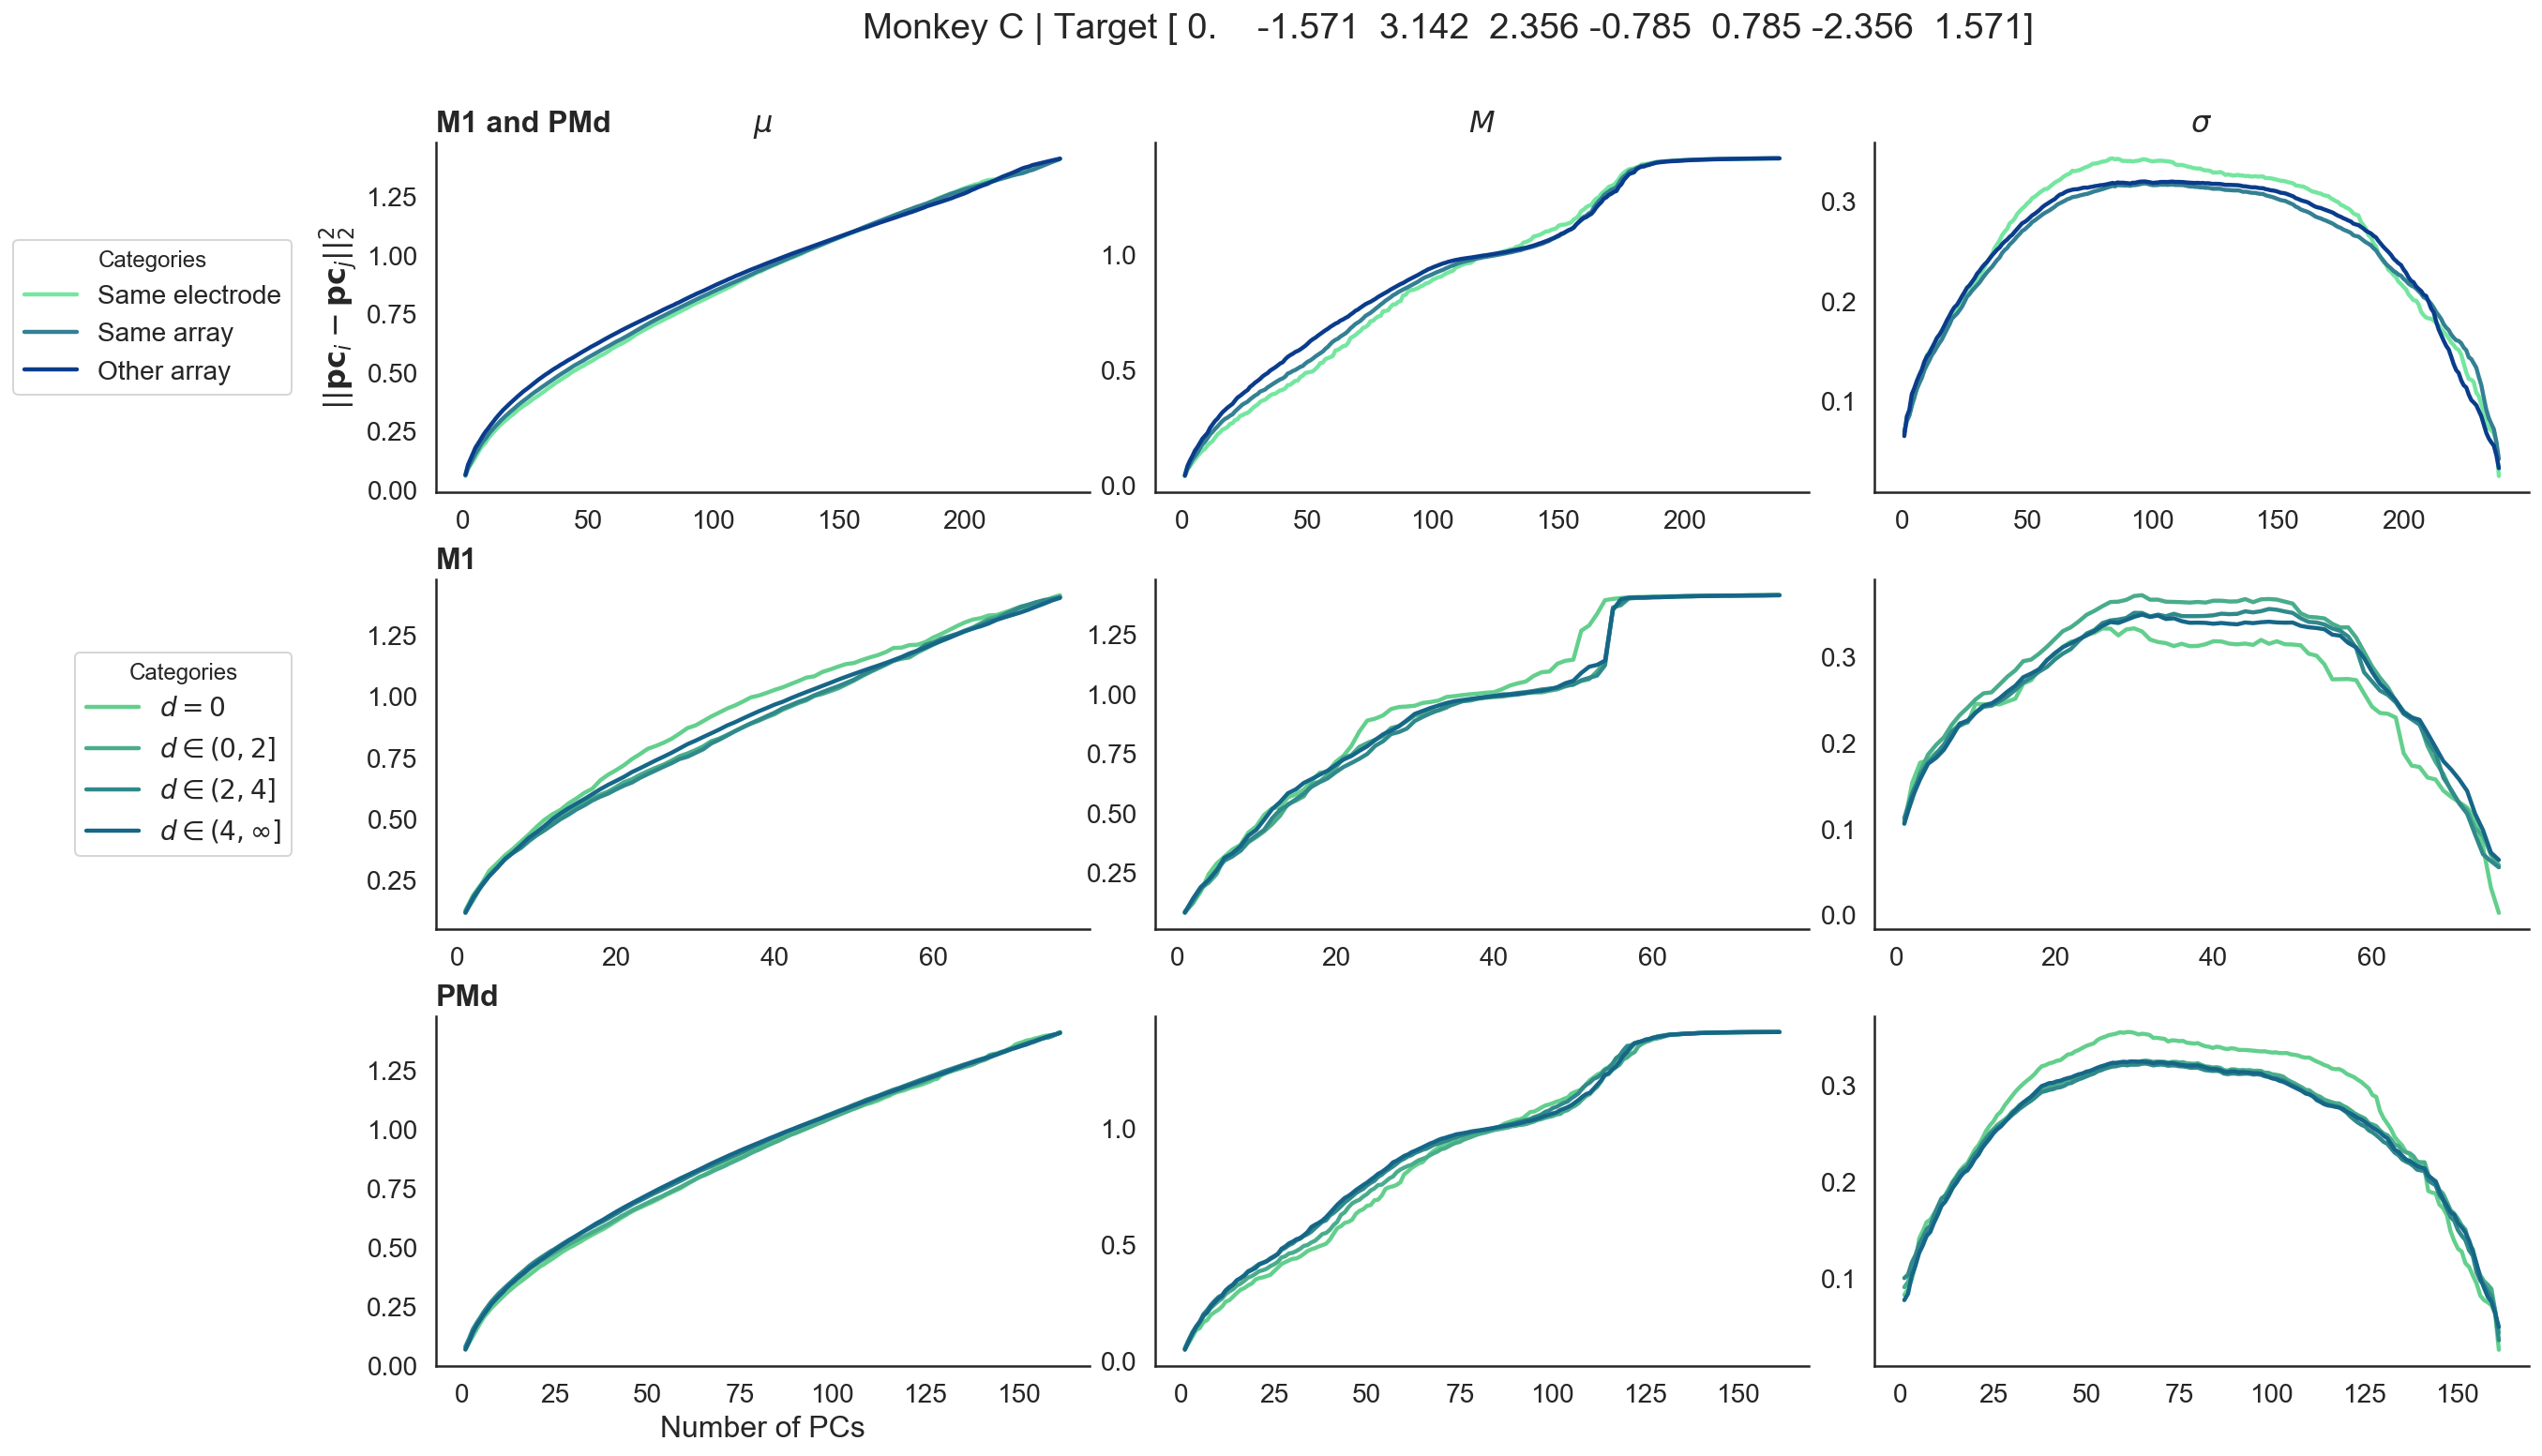

In [21]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#74E6A0', '#348093', '#0A3C8B'])

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 12), gridspec_kw={'wspace':0.1, 'hspace':0.25})

fig.suptitle(f'Monkey {monkey} | Target {target_angle}', y=0.96)
axs[0, 0].set_title('M1 and PMd', fontweight='bold', fontsize=16, loc='left')

axs[0, 0].set_title(r'$\mu$')
axs[0, 0].plot(pc_range_all, means_emp[0, :], label='Same electrode')
axs[0, 0].plot(pc_range_all, means_emp[1, :], label='Same array')
axs[0, 0].plot(pc_range_all, means_emp[2, :], label='Other array')

axs[0, 1].set_title(r'$M$')
axs[0, 1].plot(pc_range_all, medians_emp[0, :])
axs[0, 1].plot(pc_range_all, medians_emp[1, :])
axs[0, 1].plot(pc_range_all, medians_emp[2, :])

# Plot all the standard deviations
axs[0, 2].set_title(r'$\sigma$')
axs[0, 2].plot(pc_range_all, stds_emp[0, :])
axs[0, 2].plot(pc_range_all, stds_emp[1, :])
axs[0, 2].plot(pc_range_all, stds_emp[2, :])

axs[0, 0].set_ylabel(r'$|| \mathbf{pc}_i - \mathbf{pc}_j ||_2^2$')
axs[0, 0].legend(loc='center right', bbox_to_anchor=(-0.2, 0.5), fontsize=14, title='Categories', markerscale=2)

axs[1, 0].set_title('M1', fontweight='bold', fontsize=16, loc='left')
# === within M1 ===
axs[1, 0].plot(pc_range_m1, m1_within_mean[0, :], color='#63CF8D', label=r'$d = 0$')
axs[1, 0].plot(pc_range_m1, m1_within_mean[1, :], color='#49AC8B', label=r'$d \in (0, 2]$')
axs[1, 0].plot(pc_range_m1, m1_within_mean[2, :], color='#30898A', label=r'$d \in (2, 4]$')
axs[1, 0].plot(pc_range_m1, m1_within_mean[3, :], color='#166688', label=r'$d \in (4, \infty]$')

axs[1, 1].plot(pc_range_m1, m1_within_median[0, :], color='#63CF8D',)
axs[1, 1].plot(pc_range_m1, m1_within_median[1, :], color='#49AC8B')
axs[1, 1].plot(pc_range_m1, m1_within_median[2, :], color='#30898A')
axs[1, 1].plot(pc_range_m1, m1_within_median[3, :], color='#166688')

axs[1, 2].plot(pc_range_m1, m1_within_std[0, :], color='#63CF8D',)
axs[1, 2].plot(pc_range_m1, m1_within_std[1, :], color='#49AC8B')
axs[1, 2].plot(pc_range_m1, m1_within_std[2, :], color='#30898A')
axs[1, 2].plot(pc_range_m1, m1_within_std[3, :], color='#166688')

axs[2, 0].set_title('PMd', fontweight='bold', fontsize=16, loc='left')
# === Within PMd ===
axs[2, 0].plot(pc_range_pmd, pmd_within_mean[0, :], color='#63CF8D',)
axs[2, 0].plot(pc_range_pmd, pmd_within_mean[1, :], color='#49AC8B')
axs[2, 0].plot(pc_range_pmd, pmd_within_mean[2, :], color='#30898A')
axs[2, 0].plot(pc_range_pmd, pmd_within_mean[3, :], color='#166688')

axs[2, 1].plot(pc_range_pmd, pmd_within_median[0, :], color='#63CF8D',)
axs[2, 1].plot(pc_range_pmd, pmd_within_median[1, :], color='#49AC8B')
axs[2, 1].plot(pc_range_pmd, pmd_within_median[2, :], color='#30898A')
axs[2, 1].plot(pc_range_pmd, pmd_within_median[3, :], color='#166688')

axs[2, 2].plot(pc_range_pmd, pmd_within_std[0, :], color='#63CF8D',)
axs[2, 2].plot(pc_range_pmd, pmd_within_std[1, :], color='#49AC8B')
axs[2, 2].plot(pc_range_pmd, pmd_within_std[2, :], color='#30898A')
axs[2, 2].plot(pc_range_pmd, pmd_within_std[3, :], color='#166688')

axs[2, 0].set_xlabel('Number of PCs')
axs[1, 0].legend(loc='center right', bbox_to_anchor=(-0.2, 0.5), fontsize=14, title='Categories', markerscale=2)

sns.despine()